In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sallers'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost', 
    user='root',
    password='@Mysql123$',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/priya/OneDrive/Documents/PORTFOLIO PROJECTS/E-Commerce-target_dataset"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db=mysql.connector.connect(host="localhost",username="root"
                           ,password="@Mysql123$",database="ecommerce")
cur=db.cursor()


# 1. List all unique cities where customers are located.

In [5]:
query="""select distinct (customer_city) from customers limit 10"""
cur.execute(query)
data=cur.fetchall()
data


[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',)]

# 2. Count the number of orders placed in 2017.

In [7]:
query="""select count(orders.order_id) from orders
WHERE EXTRACT(YEAR FROM order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 270606)

# 3. Find the total sales per category.

In [9]:
query="""SELECT products.product_category, SUM(payments.payment_value) AS total_payment
FROM products
INNER JOIN order_items ON products.product_id = order_items.product_id 
INNER JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
limit 10
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","total_sales"])
df

,category,total_sales
0,perfumery,4.053909e+06
1,Furniture Decoration,1.144141e+07
2,telephony,3.895056e+06
3,bed table bath,1.370043e+07
4,automotive,6.818355e+06
5,computer accessories,1.268264e+07
6,housewares,8.758065e+06
7,babies,4.318765e+06
8,toys,4.952302e+06
9,Furniture office,5.174612e+06


##  Calculate the percentage of orders that were paid in installments.

In [11]:
query="""SELECT sum(case when payments. payment_installments >=1 
  then 1 else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()

"Percentage of orders that were paid in installments is", data[0]

('Percentage of orders that were paid in installments is',
 (Decimal('99.9981'),))

# Count the number of customers from each state. 


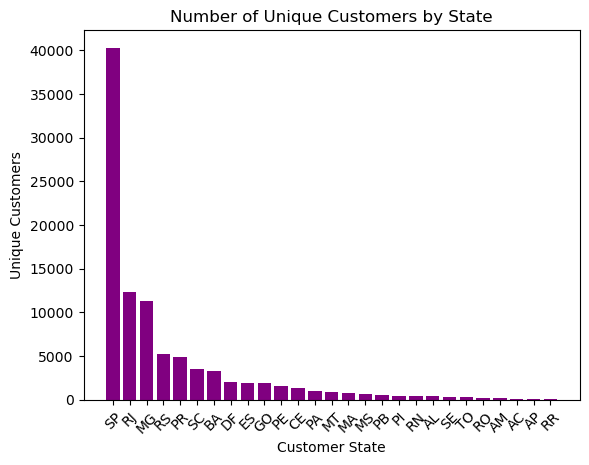

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


query = """
    SELECT 
        customers.customer_state, 
        COUNT(DISTINCT customers.customer_unique_id) AS unique_customer_count
    FROM customers
    GROUP BY customers.customer_state
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_state", "unique_customer_count"])
df=df.sort_values(by="unique_customer_count",ascending=False)


plt.bar(df["customer_state"], df["unique_customer_count"], color='purple')


plt.xlabel("Customer State")
plt.ylabel("Unique Customers")
plt.title("Number of Unique Customers by State")

plt.xticks(rotation=45) 


plt.show()


# Calculate the number of orders per month in 2018.

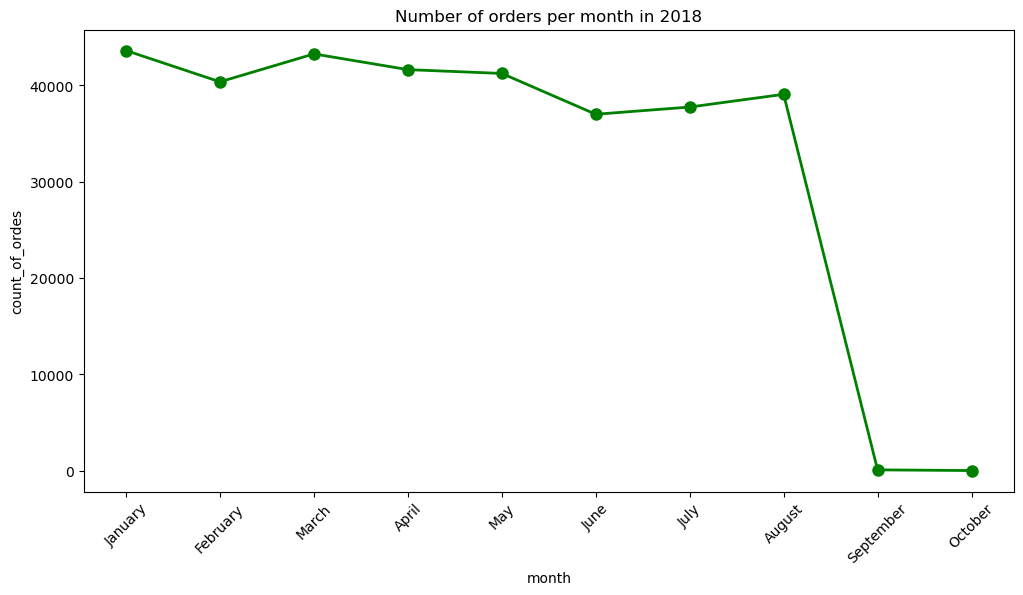

In [17]:

query="""SELECT
monthname(order_purchase_timestamp),count(order_id)
FROM orders
WHERE YEAR(order_purchase_timestamp)=2018
group by monthname(order_purchase_timestamp)
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","count_of_ordes"])
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]


df["months"] = pd.Categorical(df["months"], categories=month_order, ordered=True)

df = df.sort_values("months")



plt.figure(figsize=(12, 6))  
plt.plot(df["months"], df["count_of_ordes"], marker='o', linestyle='-', color='green', linewidth=2, markersize=8)
plt.xlabel("month")
plt.ylabel("count_of_ordes")
plt.title("Number of orders per month in 2018")

plt.xticks(rotation=45)

plt.show()        
        

# Find the average number of products per order, grouped by customer city.

In [19]:
query="""WITH A AS (
    SELECT
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.product_id) AS count
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT
    customers.customer_city,
    AVG(A.count) AS avg_product_count
FROM customers
JOIN A ON customers.customer_id = A.customer_id
GROUP BY customers.customer_city
order by avg_product_count desc;
    """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city","average_product_count"])
df.head()

,customer_city,average_product_count
0,padre carvalho,84.0000
1,celso ramos,78.0000
2,datas,72.0000
3,candido godoi,72.0000
4,matias olimpio,60.0000


#  Calculate the percentage of total revenue contributed by each product category.

In [22]:
query="""with A as (SELECT products.product_category, SUM(payments.payment_value) AS total_payment
FROM products
INNER JOIN order_items ON products.product_id = order_items.product_id 
INNER JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
limit 10)
SELECT
    A.product_category,
    (A.total_payment / (SELECT SUM(total_payment) FROM A) * 100) AS percentage_contribution
FROM A"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["product_category","percentage"])
df.head()



,product_category,percentage
0,perfumery,5.348479
1,Furniture Decoration,15.095096
2,telephony,5.138899
3,bed table bath,18.075507
4,automotive,8.995719


# Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
query="""SELECT 
    A.product_category, round(AVG(B.price),2),
    COUNT(DISTINCT B.order_id) AS order_count
FROM products AS A
JOIN order_items AS B 
ON A.product_id = B.product_id
GROUP BY A.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["product_category","average_price","distinct_count_of_orders"])
correlation = df["distinct_count_of_orders"].corr(df["average_price"])
print(f"Correlation between order count and price: {correlation:.2f}")



Correlation between order count and price: -0.10


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Execute Query
query = """SELECT 
    A.product_category, 
    round(AVG(B.price),2) AS average_price,
    COUNT(DISTINCT B.order_id) AS distinct_count_of_orders
FROM products AS A
JOIN order_items AS B 
ON A.product_id = B.product_id
WHERE B.price IS NOT NULL  -- Ensure no NULL values
GROUP BY A.product_category"""

cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=["product_category", "average_price", "distinct_count_of_orders"])

# Compute Correlation
correlation = df["distinct_count_of_orders"].corr(df["average_price"])
print(f"Correlation between order count and price: {correlation:.2f}")





Correlation between order count and price: -0.10


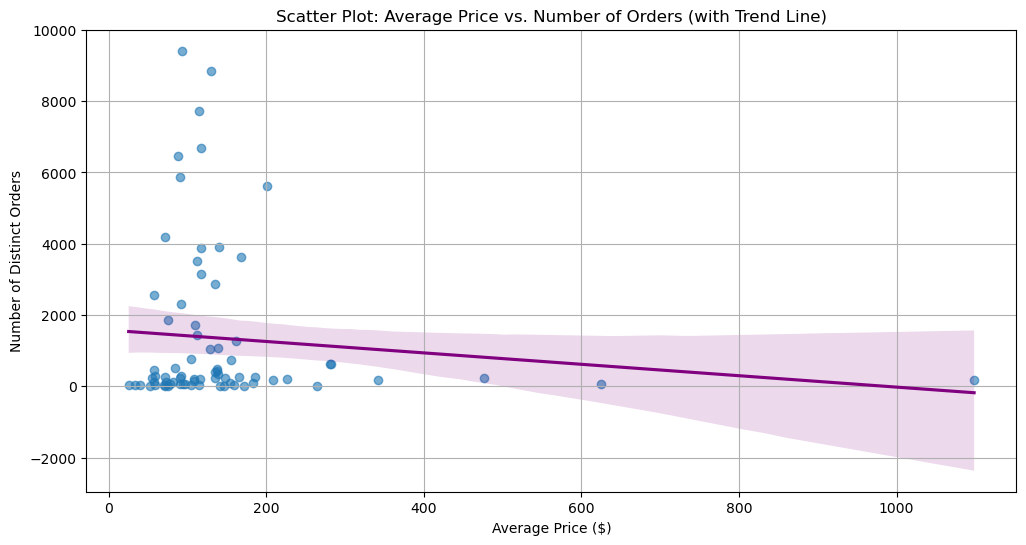

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


query = """SELECT 
    A.product_category, 
    round(AVG(B.price),2) AS average_price,
    COUNT(DISTINCT B.order_id) AS distinct_count_of_orders
FROM products AS A
JOIN order_items AS B 
ON A.product_id = B.product_id
WHERE B.price IS NOT NULL
GROUP BY A.product_category"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["product_category", "average_price", "distinct_count_of_orders"])


df.fillna(0, inplace=True)  
df["average_price"] = df["average_price"].astype(float)
df["distinct_count_of_orders"] = df["distinct_count_of_orders"].astype(int)


df["category_index"] = np.arange(len(df))


plt.figure(figsize=(12, 6))
sns.regplot(x=df["average_price"], y=df["distinct_count_of_orders"], scatter_kws={'alpha':0.6}, line_kws={"color": "purple"})


plt.xlabel("Average Price ($)")
plt.ylabel("Number of Distinct Orders")
plt.title("Scatter Plot: Average Price vs. Number of Orders (with Trend Line)")
plt.grid(True)
plt.show()

# Calculate the total revenue generated by each seller, and rank them by revenue.


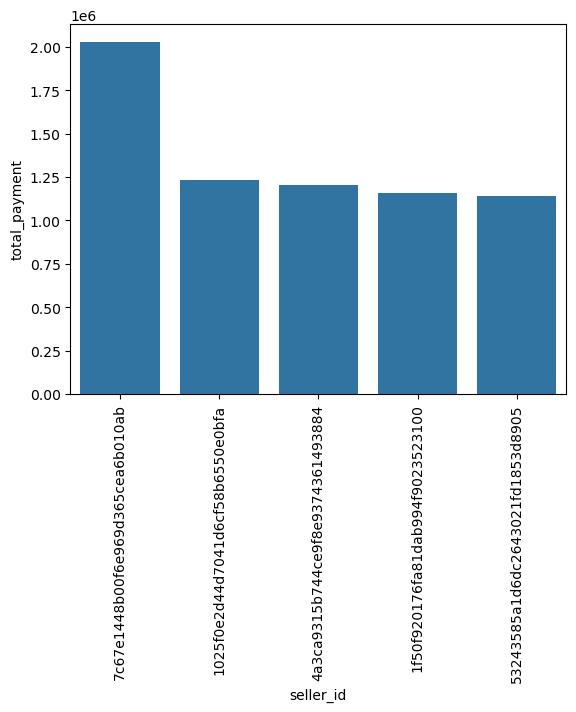

In [30]:
query ="""SELECT 
order_items.seller_id,sum(payments.payment_value),
dense_rank() OVER (ORDER BY SUM(payments.payment_value) DESC) AS payment_rank
from payments join order_items on
payments.order_id=order_items.order_id
group by order_items.seller_id"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["seller_id", "total_payment", "payment_rank"])
df=df.head()
sns.barplot(x="seller_id",y="total_payment",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

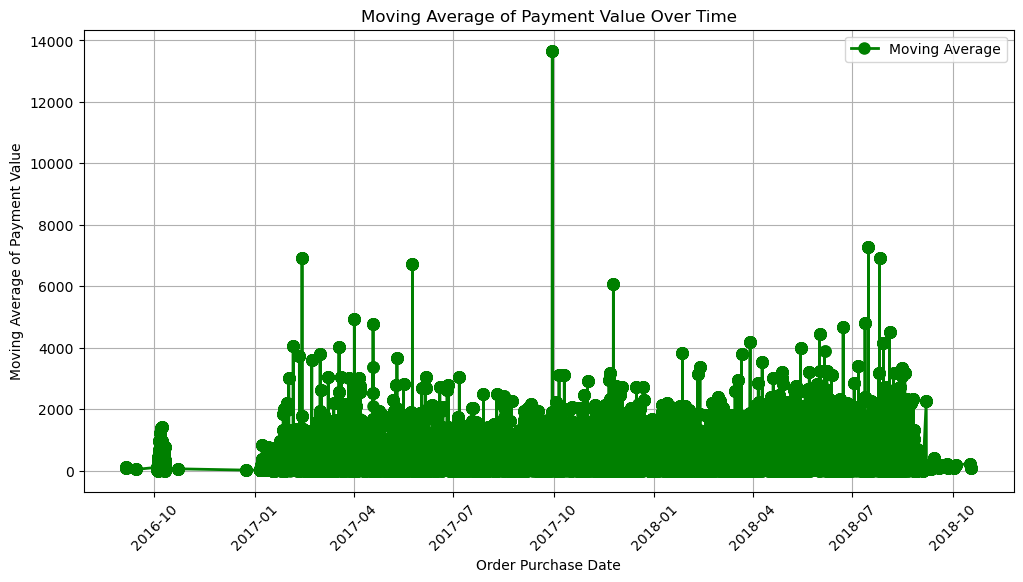

In [32]:
query="""select order_id,order_purchase_timestamp,avg(payment_value)over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row )as moving_average from
(SELECT 
orders.order_id,orders.customer_id
,orders.order_purchase_timestamp,payments.payment_value
from orders join payments on orders.order_id=payments.order_id)as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["order_id","order_purchase_timestamp","moving_average"])
df.head()
# Convert timestamp column to datetime format
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

# Sort values by timestamp
df = df.sort_values("order_purchase_timestamp")

# Plot the Moving Average

       
plt.figure(figsize=(12, 6))
plt.plot(df["order_purchase_timestamp"], df["moving_average"], label="Moving Average",marker='o', linestyle='-', color='green', linewidth=2, markersize=8)

# Labels & Title
plt.xlabel("Order Purchase Date")
plt.ylabel("Moving Average of Payment Value")
plt.title("Moving Average of Payment Value Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show Plot
plt.show()


#  Calculate the cumulative sales per month for each year.

In [34]:
query="""select year,month,payment,sum(payment) over(order by year,month)cumulative_sells
from
(SELECT
YEAR(orders.order_purchase_timestamp) AS year,
MONTH(orders.order_purchase_timestamp) AS month,
round(sum(payments.payment_value),2) as payment
FROM orders
join
payments
on orders.order_id=payments.order_id
group by year,month
ORDER BY year, month) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["year","month","sells","cumulative_sells"])
df.head()

,year,month,sells,cumulative_sells
0,2016,9,3026.88,3026.88
1,2016,10,709085.76,712112.64
2,2016,12,235.44,712348.08
3,2017,1,1661856.48,2374204.56
4,2017,2,3502896.11,5877100.67


#  Calculate the year-over-year growth rate of total sales.

In [36]:
query="""select year, 
round(((payment-lag(payment,1) over(order by year))/lag(payment,1) over(order by year)*100),2)as yoy
from
(SELECT
YEAR(orders.order_purchase_timestamp) AS year,

round(sum(payments.payment_value),2) as payment
FROM orders
join
payments
on orders.order_id=payments.order_id
group by year
ORDER BY year) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["year","yoy"])
df


,year,yoy
0,2016,NaN
1,2017,12112.7
2,2018,20.0


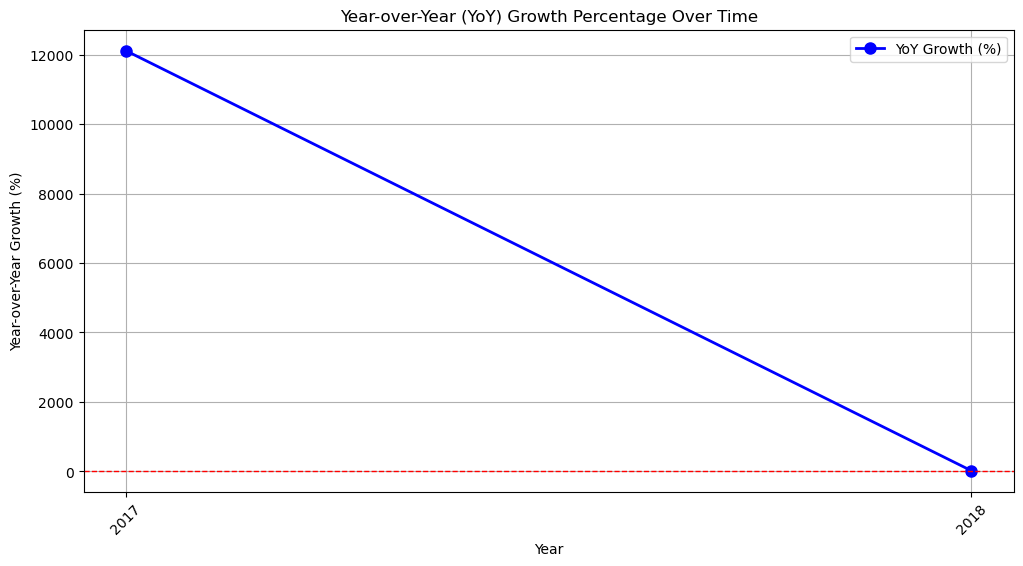

In [38]:
import matplotlib.pyplot as plt


df["year"] = df["year"].astype(str)


plt.figure(figsize=(12, 6))
plt.plot(df["year"], df["yoy"], marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label="YoY Growth (%)")

plt.xlabel("Year")
plt.ylabel("Year-over-Year Growth (%)")
plt.title("Year-over-Year (YoY) Growth Percentage Over Time")
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.legend()
plt.grid()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [40]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

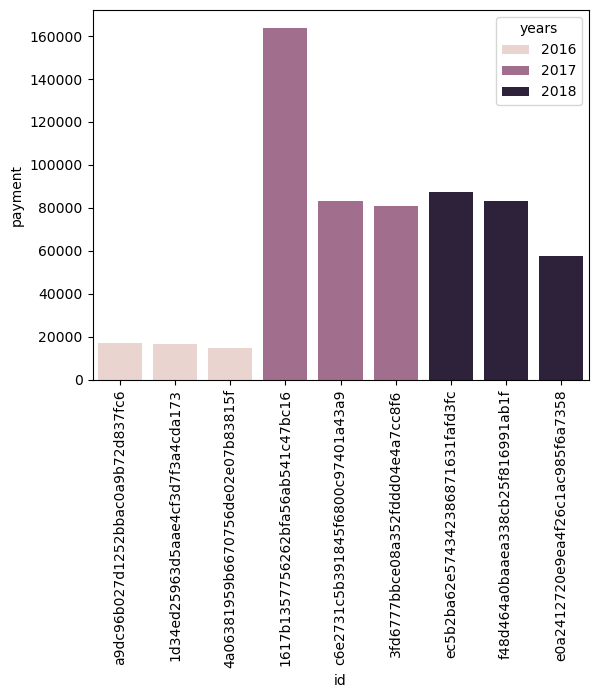

In [43]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()